# __Springboard Data Science Capstone 3 Project__
# _Predicting the Price of Energy_

### Pre-Processing & Modeling

##### _Ben Takacs_
###### __Python version 3.10.4__

### __Imports and File Location__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import load_csv_data, arima_mse, model_eval, sarima_mse

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,  mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose


### __Load Data__

In [2]:
df = pd.read_csv('./data/df1.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df

,"Average Price of Electricity to Ultimate Customers, Residential",Total Renewable Energy Consumption,Total Petroleum Consumed by the Residential Sector,Natural Gas Consumed by the Electric Power Sector,"Natural Gas Consumed by the Transportation Sector, Vehicle Fuel"
Month,,,,,
1990-02-01,7.48,0.321465,143.972,153.181,0.021
1990-03-01,7.57,0.353956,129.117,214.167,0.023
1990-04-01,7.69,0.334136,108.024,231.641,0.022
1990-05-01,7.96,0.317791,94.930,283.776,0.023
1990-06-01,8.10,0.289276,87.671,345.768,0.022
...,...,...,...,...,...
2024-05-01,16.43,0.758321,53.691,1045.631,4.514
2024-06-01,16.42,0.742351,40.900,1243.853,4.368
2024-07-01,16.63,0.733689,31.619,1534.444,4.514


Average price is in units of cents per kilowatt hour, including taxes.\
Renewable energy consumption is in units of quadrillion Btu (10^15)\
Petroleum consumption is in units of trillion Btu (10^12)\
Natural gas consumed is in units of billion cubic feet (10^12)\
Need to convert  energies to same unit.
Also going to rename columsn to something easier.

In [3]:
df.rename(columns={'Average Price of Electricity to Ultimate Customers, Residential':'Price', 'Total Renewable Energy Consumption':'Renewable', 'Total Petroleum Consumed by the Residential Sector':'Petroleum', 'Natural Gas Consumed by the Electric Power Sector':'Electric', 'Natural Gas Consumed by the Transportation Sector, Vehicle Fuel':'Transportation'}, inplace=True)
df.Renewable *= 1e3
df

,Price,Renewable,Petroleum,Electric,Transportation
Month,,,,,
1990-02-01,7.48,321.465,143.972,153.181,0.021
1990-03-01,7.57,353.956,129.117,214.167,0.023
1990-04-01,7.69,334.136,108.024,231.641,0.022
1990-05-01,7.96,317.791,94.930,283.776,0.023
1990-06-01,8.10,289.276,87.671,345.768,0.022
...,...,...,...,...,...
2024-05-01,16.43,758.321,53.691,1045.631,4.514
2024-06-01,16.42,742.351,40.900,1243.853,4.368
2024-07-01,16.63,733.689,31.619,1534.444,4.514


Renewable and Petroleum now have same units (trillion Btu)

In [4]:
exog = pd.read_csv('./data/exog.csv', index_col=0)
exog.set_index(pd.to_datetime(exog.index), inplace=True)
exog

,Population,GDP
Month,,
1990-02-01,252.273689,10058.925806
1990-03-01,252.500884,10087.247931
1990-04-01,252.728323,10115.630336
1990-05-01,252.956003,10144.072517
1990-06-01,253.183924,10172.573960
...,...,...
2024-05-01,335.258213,23340.273105
2024-06-01,335.309775,23404.211001
2024-07-01,335.359756,23468.810867


##### Don't need to scale data because it's a time series

### __Test Train Split__

In [37]:
# Make differenced dataframe as well for use with modeling
df_diff = pd.DataFrame()
for col in df.columns:
    df_diff[col] = np.diff(df[col])

df_diff.index = df.index[:-1]
df_diff

,Price,Renewable,Petroleum,Electric,Transportation
Month,,,,,
1990-02-01,0.09,32.491,-14.855,60.986,0.002
1990-03-01,0.12,-19.820,-21.093,17.474,-0.001
1990-04-01,0.27,-16.345,-13.094,52.135,0.001
1990-05-01,0.14,-28.515,-7.259,61.992,-0.001
1990-06-01,0.08,26.596,-2.301,33.816,0.001
...,...,...,...,...,...
2024-04-01,-0.45,21.792,-17.515,163.693,0.146
2024-05-01,-0.01,-15.970,-12.791,198.222,-0.146
2024-06-01,0.21,-8.662,-9.281,290.591,0.146


In [38]:
split = 0.65

#Endogenous vars
# normal
train, test = train_test_split(df, train_size=split, shuffle=False)
ytrain = train.Price; ytest = test.Price
xtrain = train.drop(columns='Price'); xtest = test.drop(columns='Price')

# differenced
train_diff, test_diff = train_test_split(df_diff, train_size=split, shuffle=False)
ytrain_diff = train_diff.Price; ytest_diff = test_diff.Price
xtrain_diff = train_diff.drop(columns='Price')
xtest_diff = test_diff.drop(columns='Price')

# Exogenous vars
extrain, extest = train_test_split(exog, train_size=split, shuffle=False)

In [41]:
print(train.shape, test.shape)
print(extrain.shape, extest.shape)
print(train_diff.shape, test_diff.shape)

(270, 5) (146, 5)
(270, 2) (146, 2)
(269, 5) (146, 5)


### __ARIMA Modeling__

Only takes one variable, price. 

### Eyeball Analysis

From our ACF and PACF analysis in the EDA section, we guessed a good model would be ARIMA of order (1,1,1) or (1,1,2).

In [26]:
model_price_1 = ARIMA(ytrain_diff, order=(1,1,1))
model_price_1_fit = model_price_1.fit()
print(model_price_1_fit.summary())

model_price_2 = ARIMA(ytrain_diff, order=(1,1,2))
model_price_2_fit = model_price_2.fit()
print(model_price_2_fit.summary())

aic_delta = model_price_2_fit.aic - model_price_1_fit.aic
print(aic_delta)

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  269
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  39.340
Date:                Fri, 14 Mar 2025   AIC                            -72.681
Time:                        15:20:20   BIC                            -61.908
Sample:                    02-01-1990   HQIC                           -68.354
                         - 06-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3320      0.237     -1.400      0.161      -0.797       0.133
ma.L1          0.0997      0.254      0.392      0.695      -0.398       0.598
sigma2         0.0436      0.003     13.430      0.0

/Users/bencetakacs/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bencetakacs/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bencetakacs/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bencetakacs/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bencetakacs/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_mod

Model of order (1,1,1) has lower AIC.

### Now we can search a range of orders to find the best fit (here lowest AIC, next on MSE as well)

In [27]:
# Range of pdq values to test
p = [x for x in range(0, 3)]
d = [x for x in range(0, 3)]
q = [x for x in range(0, 3)]

import warnings
warnings.filterwarnings('ignore')

aic_test = np.inf
for i in p:
    for j in d:
        for k in q:
            try:
                model = ARIMA(ytrain_diff, order=(i, j, k))
                model_fit = model.fit()
                if model_fit.aic < aic_test:
                    aic_test = model_fit.aic
                    best_order_price = (i, j, k)
            except:
                continue

print('\nBest Order:', best_order_price)

# import warnings
# warnings.filterwarnings("ignore")
# best_order_price = model_eval(np.diff(ytrain), p, d, q)


Best Order: (2, 0, 2)


d = 0 means data was not differenced (because we already differenced it)

In [28]:
best_price_mse = model_eval(ytrain_diff, p, d, q)

Evaluating ARIMA models...
ARIMA(0, 0, 0) MSE=7.000E-02
ARIMA(0, 0, 1) MSE=5.160E-02
ARIMA(0, 0, 2) MSE=4.785E-02
ARIMA(0, 1, 0) MSE=6.009E-02
ARIMA(0, 1, 1) MSE=6.164E-02
ARIMA(0, 1, 2) MSE=6.368E-02
ARIMA(0, 2, 0) MSE=1.279E-01
ARIMA(0, 2, 1) MSE=6.035E-02
ARIMA(0, 2, 2) MSE=6.183E-02
ARIMA(1, 0, 0) MSE=4.777E-02
ARIMA(1, 0, 1) MSE=4.816E-02
ARIMA(1, 0, 2) MSE=4.960E-02
ARIMA(1, 1, 0) MSE=6.227E-02
ARIMA(1, 1, 1) MSE=6.238E-02
ARIMA(1, 1, 2) MSE=6.360E-02
ARIMA(1, 2, 0) MSE=9.305E-02
ARIMA(1, 2, 1) MSE=6.247E-02
ARIMA(1, 2, 2) MSE=6.257E-02
ARIMA(2, 0, 0) MSE=4.856E-02
ARIMA(2, 0, 1) MSE=4.881E-02
ARIMA(2, 0, 2) MSE=3.016E-02
ARIMA(2, 1, 0) MSE=6.257E-02
ARIMA(2, 1, 1) MSE=6.090E-02
ARIMA(2, 1, 2) MSE=5.162E-02
ARIMA(2, 2, 0) MSE=9.032E-02
ARIMA(2, 2, 1) MSE=6.276E-02
ARIMA(2, 2, 2) MSE=6.340E-02
Best ARIMA(2, 0, 2) MSE=3.016E-02


MSE chose same model

In [29]:
forecast_length = 36 # forecast 3 years

model_arima1 = ARIMA(ytrain_diff, order=best_order_price)
model_arima_fit1 = model_arima1.fit()
forecast_arima1 = model_arima_fit1.forecast(steps=forecast_length)
model_arima_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  269
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 157.527
Date:                Fri, 14 Mar 2025   AIC                           -303.054
Time:                        15:23:36   BIC                           -281.486
Sample:                    02-01-1990   HQIC                          -294.392
                         - 06-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0143      0.007      2.183      0.029       0.001       0.027
ar.L1          1.7313      0.006    303.801      0.000       1.720       1.742
ar.L2         -0.9950      0.005   -190.569      0.000      -1.005      -0.985
ma.L1         -1.7533      0.025    -69.512      0.000      -1.803      -1.704
ma.L2          0.9564      0.025     38.680      0.000       0.908       1.005
sigma2         0.0177      0.002     11.318      0.000       0.015       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.41   Prob(JB):                         0.97
Heteroskedasticity (H):               2.41   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAE: 0.413
MSE: 0.237


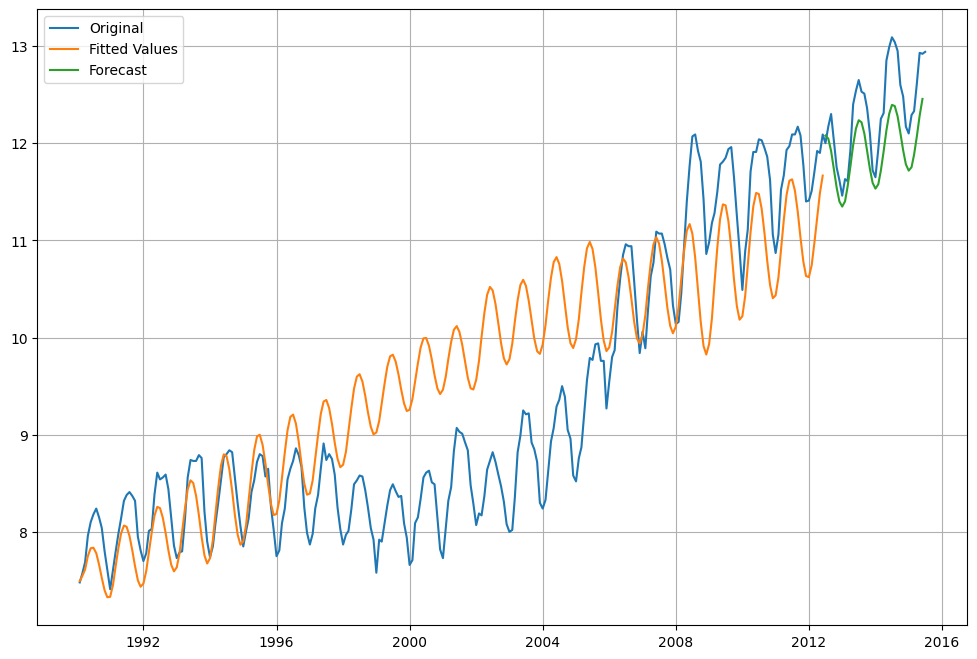

In [82]:
print('MAE: {:.3f}\nMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], forecast_arima1.cumsum()+ytrain[-1]),
    mean_squared_error(ytest[:forecast_length], forecast_arima1.cumsum()+ytrain[-1])
))


plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
plt.plot(model_arima_fit1.fittedvalues.cumsum()+ytrain[0], label='Fitted Values')
plt.plot(forecast_arima1.cumsum()+ytrain[-1], label='Forecast')
plt.grid(True)
plt.legend()
plt.show()

Model does not perform very well, fitted values are off as well as predicted values, MAE is 0.4.

### __SARIMAX Model__

SARIMAX can take exogenous variables as well as endogenous.

In [84]:
model_sarima1 = SARIMAX(ytrain, exog=extrain, order=(2, 1, 2))
model_sarima_fit1 = model_sarima1.fit(disp=False)
print(model_sarima_fit1.summary())

pred_sarima1 = model_sarima_fit1.forecast(
    steps=forecast_length, exog=extest[:forecast_length]
)

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  270
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 144.785
Date:                Fri, 14 Mar 2025   AIC                           -275.570
Time:                        15:43:25   BIC                           -250.407
Sample:                    02-01-1990   HQIC                          -265.464
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population     2.5055      0.673      3.721      0.000       1.186       3.825
GDP           -0.0195      0.005     -3.603      0.000      -0.030      -0.009
ar.L1          1.6916      0.021     80.874      0.0

MAE: 1.270
MSE: 2.443


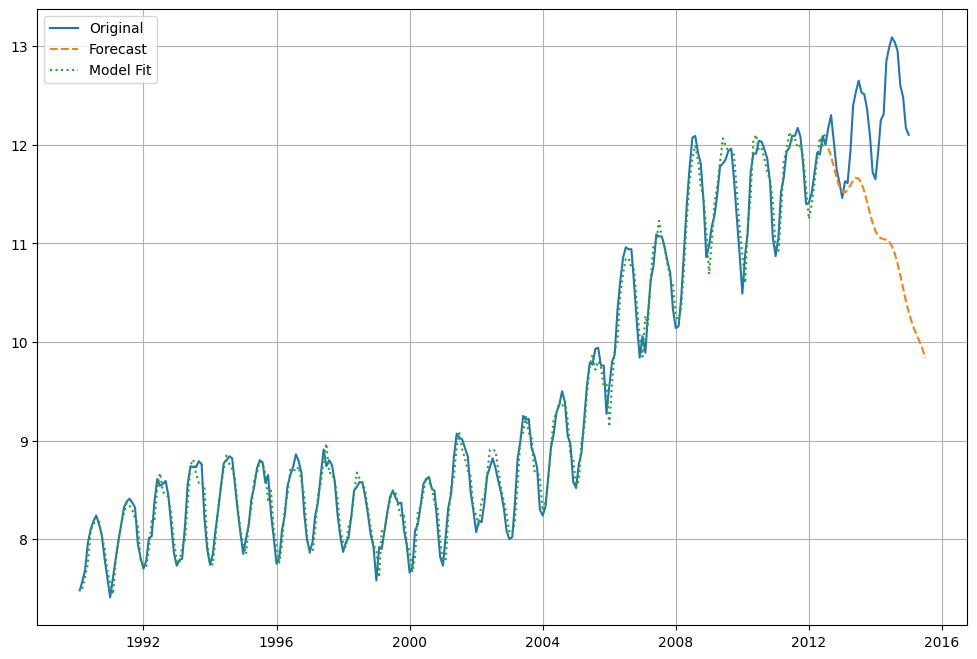

In [87]:
print('MAE: {:.3f}\nMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_sarima1),
    mean_squared_error(ytest[:forecast_length], pred_sarima1)
))

plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:30]]), label='Original')
# plt.plot(pred_sarima1.cumsum()+ytrain[-1], label='Forecast', ls='--')
plt.plot(pred_sarima1, label='Forecast', ls='--')
plt.plot(model_sarima_fit1.fittedvalues[1:], label='Model Fit', ls=':')
plt.grid(True)
plt.legend()
plt.show()

Fitted values are great, prediction is very off.

In [88]:
aic_test = np.inf
for i in p:
    for j in d:
        for k in q:
            try:
                model = SARIMAX(
                    ytrain, exog=extrain, order=(i, j, k),
                )
                model_fit = model.fit(disp=False)
                if model_fit.aic < aic_test:
                    aic_test = model_fit.aic
                    best_order_price = (i, j, k)
            except:
                continue

print('\nBest Order:', best_order_price)


Best Order: (2, 1, 2)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  270
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 144.785
Date:                Fri, 14 Mar 2025   AIC                           -275.570
Time:                        15:44:56   BIC                           -250.407
Sample:                    02-01-1990   HQIC                          -265.464
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population     2.5055      0.673      3.721      0.000       1.186       3.825
GDP           -0.0195      0.005     -3.603      0.000      -0.030      -0.009
ar.L1          1.6916      0.021     80.874      0.0

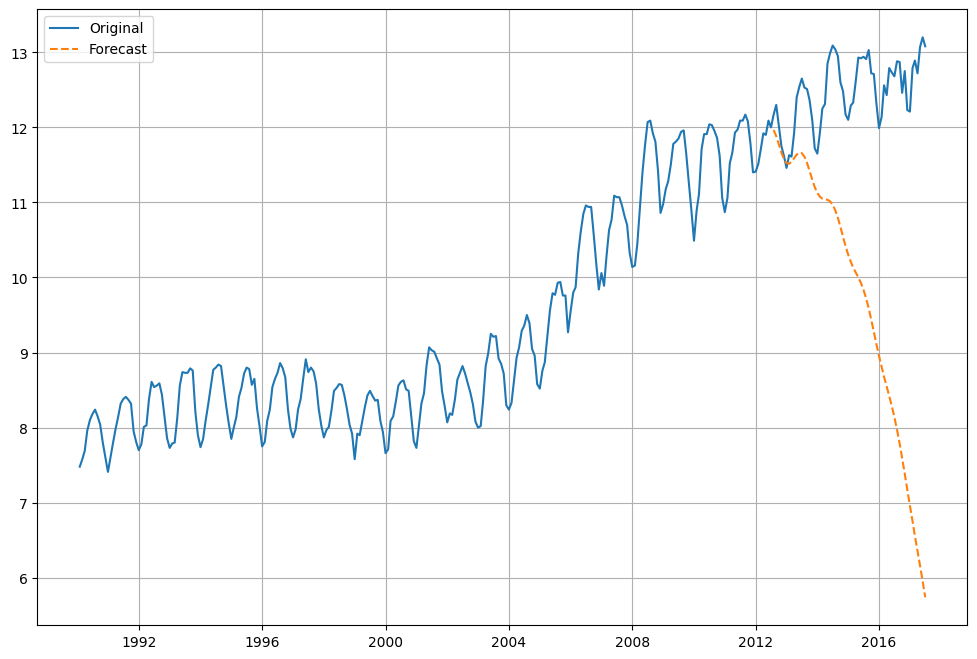

In [90]:
model = SARIMAX(ytrain, exog=extrain, order=(best_order_price))
model_fit = model.fit(disp=False)
print(model_fit.summary())

# Forecast using X_test
years = 5 # number of years to forecast
predictions = model_fit.forecast(steps=years*12, exog=extest[:years*12])

plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:years*12]]), label='Original')
# plt.plot(predictions.cumsum()+ytrain[-1], label='Forecast', ls='--')
plt.plot(predictions, label='Forecast', ls='--')
plt.grid(True)
plt.legend()
plt.show()

In [100]:
# Fit ARIMAX model using X_train features
model = SARIMAX(ytrain, exog=extrain.GDP, order=(2, 1, 2))
model_fit = model.fit(disp=False)
print(model_fit.summary())

# Forecast using X_test
predictions = model_fit.forecast(steps=30, exog=extest.GDP[:30])

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  270
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 140.234
Date:                Fri, 14 Mar 2025   AIC                           -268.467
Time:                        15:46:56   BIC                           -246.899
Sample:                    02-01-1990   HQIC                          -259.805
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
GDP            0.0005      0.000      2.854      0.004       0.000       0.001
ar.L1          1.7121      0.020     83.603      0.000       1.672       1.752
ar.L2         -0.9622      0.020    -49.021      0.0

MAE: 0.324
MSE: 0.164


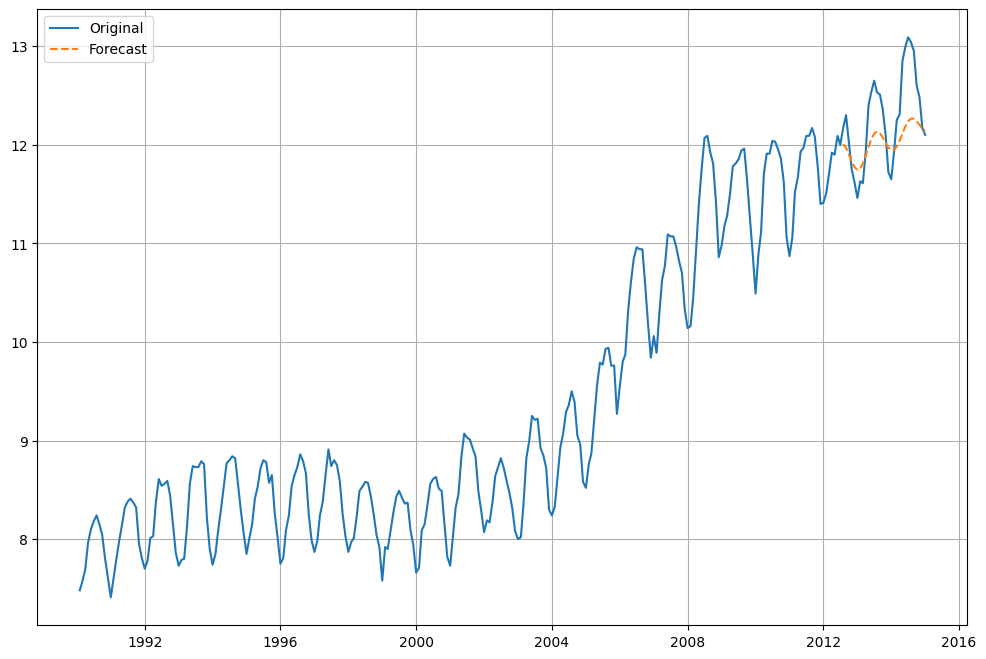

In [101]:
print('MAE: {:.3f}\nMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:30], predictions),
    mean_squared_error(ytest[:30], predictions)
))

plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:30]]), label='Original')
# plt.plot(predictions.cumsum()+ytrain[-1], label='Forecast', ls='--')
plt.plot(predictions, label='Forecast', ls='--')
plt.grid(True)
plt.legend()
plt.show()

### __VAR Model__

In [102]:
import statsmodels.tsa.stattools as tools
select_order = tools.arma_order_select_ic(y=ytrain_diff, max_ar=12, max_ma=12, )
select_order


{'bic':             0           1           2           3           4           5   \
 0   -36.160743  -95.182068 -117.174787 -123.437199 -112.558111 -125.514374   
 1  -118.954828 -113.361806  -95.618300 -125.024890 -139.220698 -129.770150   
 2  -113.363560 -108.743916 -281.485956 -275.937632 -259.647915 -267.129636   
 3  -128.685144 -199.904867 -276.171989 -269.853549 -265.616216 -246.008637   
 4  -159.150199 -211.307604 -199.155464 -264.382130 -262.899230 -249.307800   
 5  -169.372056 -210.383837 -200.120653 -238.216022 -256.957373 -249.849806   
 6  -196.470856 -219.805001 -222.025892 -196.944708 -251.561557 -250.396812   
 7  -204.502962 -217.457860 -209.110962 -200.915228 -226.102300 -241.411550   
 8  -218.171725 -222.287063 -225.051826 -198.604221 -254.705917 -239.138544   
 9  -233.189243 -227.668748 -259.069723 -253.399484 -242.118870 -255.042615   
 10 -227.805266 -222.855680 -241.667641 -251.155626 -241.125710 -238.278223   
 11 -237.772772 -261.734904 -270.462987 -265.

In [104]:
model_var = VAR(endog=train, exog=extrain)
# model_var_fit = model_var.fit(maxlags=2, ic='bic', )
model_var_fit = model_var.fit()
# print(model_var_fit.summary())
forecast_var = model_var_fit.forecast(y=train.values[-model_var_fit.k_ar:], steps=30, exog_future=extest[:30])

forecast_var = pd.DataFrame(forecast_var)
forecast_var.columns = train.columns
forecast_var.index = test.index[:len(forecast_var)]

This model sees much less correlation between Price and the other features, perhaps due to differencing.

In [105]:
forecast_var

,Price,Renewable,Petroleum,Electric,Transportation
Month,,,,,
2012-08-01,11.945547,495.365382,47.105096,943.831612,2.534245
2012-09-01,11.894674,491.715595,56.453729,861.910456,2.563983
2012-10-01,11.867211,490.735985,64.035099,810.199205,2.590549
2012-11-01,11.854949,489.475256,69.519912,776.586353,2.610830
2012-12-01,11.849540,487.691162,73.569090,754.137268,2.626408
2013-01-01,11.845595,485.510607,76.728814,738.618092,2.638914
2013-02-01,11.840067,483.058601,79.347908,727.411476,2.649486
2013-03-01,11.831409,480.417866,81.633471,718.905295,2.658851
2013-04-01,11.818964,477.637411,83.704458,712.114488,2.667456


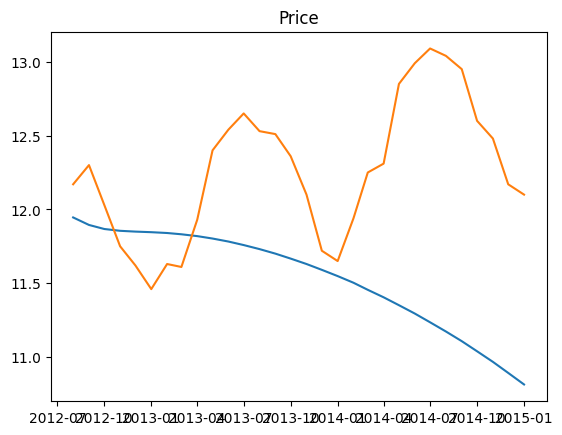

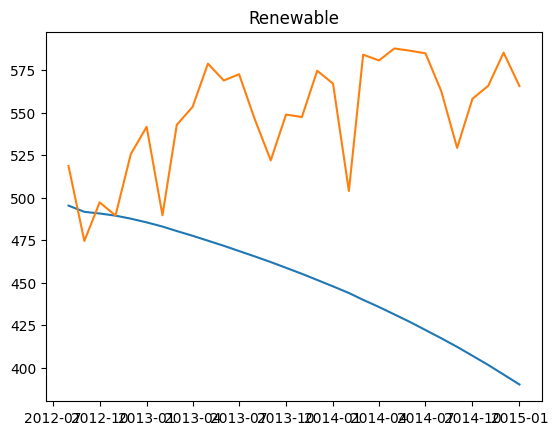

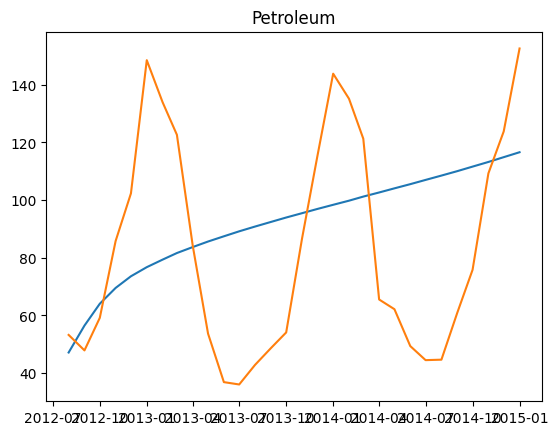

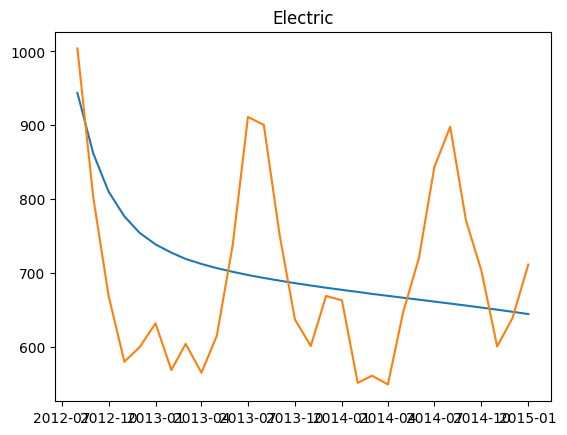

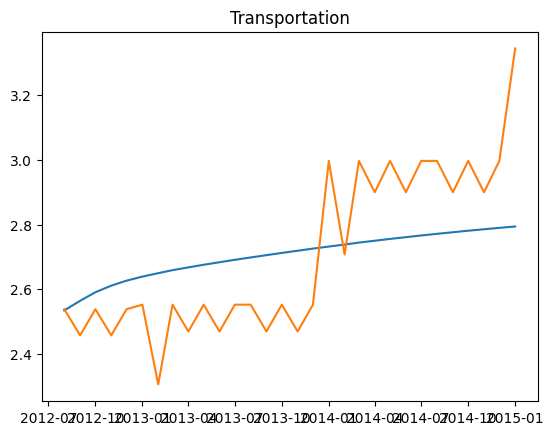

In [108]:
for col in forecast_var:
    plt.figure()
    plt.title(col)
    plt.plot(forecast_var[col], label='Prediction')
    plt.plot(test[col][:len(forecast_var)])
    plt.show()

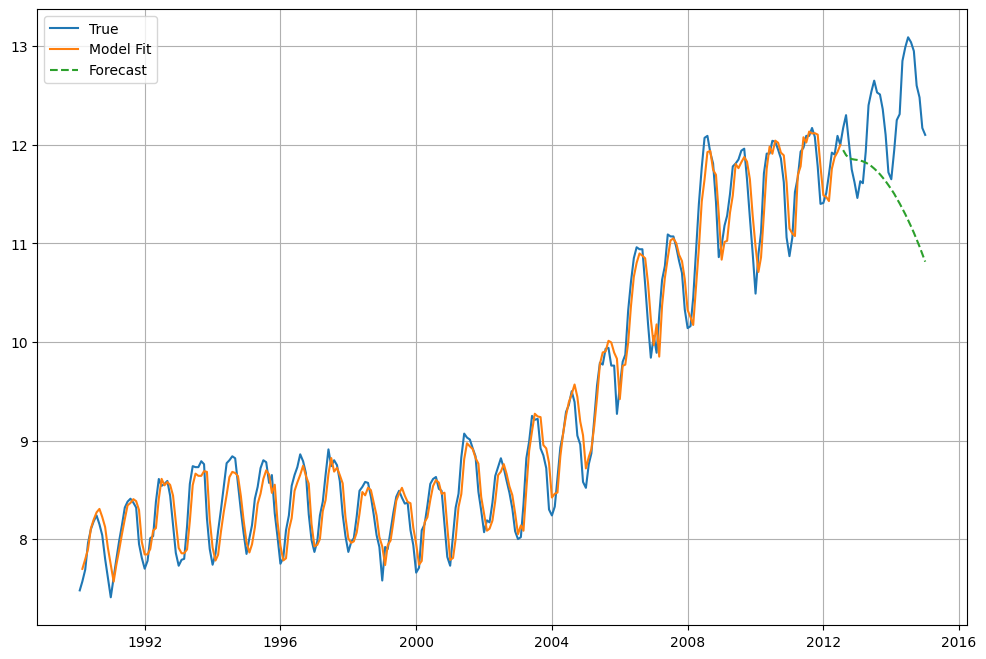

In [112]:
plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:30]]), label='True')
plt.plot(model_var_fit.fittedvalues.Price, label='Model Fit')
plt.plot(forecast_var.Price, label='Forecast', ls='--')
plt.grid(True)
plt.legend()
plt.show()

This model is not forecasting accurately, could be a problem with how the model is set up or the features we chose are not good indicators of price performance.

Future plans: Separate training and testing data using time series split.\
Modeling: ARIMA, SARIMA, FB Prophet, exponential smoothing
 RNN, XGBoost\
Employ 1 step ahead cross validation